In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Image Compression

In this exercise, you will __Apply K-means__ for image compression by reducing the number of colours that occur in an image to only those that are most common in that image.

In the previous challenge we have seen the following setting : 
- 4 clusters (or categories / classes / output / target)
- 500 observations (or samples)...
- ... of 2 dimensions each (or features): their x and y position on a 2D scatterplot

Now we're gonna apply KMeans but to a different problem : One image is gonna be our dataset. 
- Every pixel represents one observation or training sample.
- Every pixel has 3 components (red, green & blue).

## How python deals with images

### Black & white images

Each images represent a matrix where each pixel is an element of this matrix 

<img src="https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png">

The scale of colors is between 0 and 255 : 0 correspond to black and 255 to white

### Colored images :

<img src="https://miro.medium.com/max/840/1*y0nV4cWk3KbzXSe9dIWL5g.jpeg">

Every color is a linear combinaison of primary colors : Red Green Blue <br/>
A colored image is somehow just the supperposition of three images : for each pixel with have three values

A colored image is a matrix where each pixel is an array of three values (the values corresponding to R,G,B ) <br/>
A link to play with RGB online : [RGB website](https://www.colorspire.com/rgb-color-wheel/)

❓ Question : what you be the `shape` of a squared, colored, image of 10,000 pixels ?



<details>
    <summary>Answer</summary>

The image shape would be : (100, 100, 3) : 100 for width, 100 for height, 3 for the R, G, B combinaison.
This is a 3D-array (note that pandas cannot easily deal with more than 2D arrays - get ready to use Numpy ndarray
instead)
</details>


            

## Create a dataset X of one image

Execute the code below to create an image dataset - use `pip install scikit-image` to install the skimage library which has a bunch of utilities to manipulate images.

In [2]:
#!pip install scikit-image

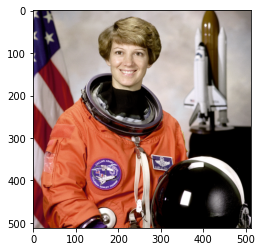

In [3]:
from skimage import data
img = data.astronaut()
plt.imshow(img)
plt.show()

In [4]:
img.shape

(512, 512, 3)

👉 What's the image shape ?

In [5]:
img_shape = img.shape

### 🧪 Test your code

In [6]:
from nbresult import ChallengeResult

result = ChallengeResult('image_shape',
                         img_shape = img_shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/smrack/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/smrack/code/olushO/data-challenges/05-ML/06-Unsupervised-Learning/01-Image-Compression
plugins: anyio-2.2.0, dash-1.20.0
collecting ... collected 1 item

tests/test_image_shape.py::TestImageShape::test_img_shape PASSED         [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/image_shape.pickle

git commit -m 'Completed image_shape step'

git push origin master


To represent it correctly for machine learning use, you want to represent every observation sample (pixel) as just a color.

For that, you need to **reshape** the image that currently has a size of `width x height x 3` to a long column vector of size N x 3 where `N = width x height`. Do it using `np.reshape` and put this dataset into a matrix X

In [7]:
X = img.reshape(img_shape[0]*img_shape[1], img_shape[-1])

In [8]:
X.shape

(262144, 3)

Right now, your image colors may contain up to 256**3 = 16M potential colors. Well, actually, it uses less colors because the image size is only 262,144 pixels. Let's count! 

👉 How many *different* colors is this picture comprised of?
<details>
    <summary>Hint</summary>

check `Pandas.DataFrame.drop_duplicates()`
</details>

In [9]:
pd.DataFrame(X).drop_duplicates()#[0].count()

,0,1,2
0,154,147,151
1,109,103,124
2,63,58,102
3,54,51,98
4,76,76,106
...,...,...,...
262132,78,78,64
262134,37,34,24
262137,71,62,62
262138,105,99,96


In [10]:
len(np.unique(X, axis=0))

113382

In [11]:
color_count = len(np.unique(X, axis=0))

### 🧪 Test your code

In [12]:
from nbresult import ChallengeResult

result = ChallengeResult('color_count',
                         color_count = color_count)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/smrack/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/smrack/code/olushO/data-challenges/05-ML/06-Unsupervised-Learning/01-Image-Compression
plugins: anyio-2.2.0, dash-1.20.0
collecting ... collected 1 item

tests/test_color_count.py::TestColorCount::test_color_count PASSED       [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/color_count.pickle

git commit -m 'Completed color_count step'

git push origin master


## Compress the image by reducing numbers of colors using K-means

- We will reduce these 113 382 colors to max **K** colors, using a KMeans algorithm over the pixels with **K** clusters!

- By choosing **K** clusers, Kmeans is trying to find **K** groups of similar pixels (close in color).

- The center of each group (or cluster) is going to be the average color of the pixels that belong to it.

- We can use this "mean color" to replace all the pixels in each cluster.

👉 First let's try to reducing the image to 32 colors. Fit a K-means

In [13]:
from sklearn.cluster import KMeans
n_colors = 32
model_32 = KMeans(n_clusters=n_colors).fit(X)

We've just created our compression! Why is that? Because the 32 cluster centers are now our new colors. 

👉 Check your computed `labels_` as well as each `cluster_centers_` of your KMean model. Make sure to understand what they represent, by investigating their shape.

In [14]:
model_32.labels_.shape, model_32.cluster_centers_.shape

((262144,), (32, 3))

As we can see, we have an assignment of every pixel to the cluster it belongs to. We will use that to find what this color is and plot our compressed image.

👉 Create an `X_compressed` variable of shape (262144, 3), which contains each pixel and their associated new colors. X is the "flattened" version of a compressed image.

In [15]:
# create an array replacing each pixel label with its corresponding cluster centroid
X_compressed = np.array([list(model_32.cluster_centers_[label]) for label in model_32.labels_])
X_compressed.shape

(262144, 3)

Almost there! 'float64' RGB values needs to be converted to integer between 0 and 255 to have a color that the computer can understand. Use `np.astype` to convert `X_compressed` to 'uint8' (8-bit) types which lies between 0 and 255

In [16]:
X_compressed = X_compressed.astype('uint8')

Double check that the number of unique colors used is indeed 32

In [17]:
pd.DataFrame(X_compressed).nunique()

0    29
1    31
2    29
dtype: int64

## Plot compressed image

Try to plot your image compressed. Take time to think about the shape of the object to pass to `plt.imshow()`

<details>
    <summary>Hint</summary>

👉You will need to transform your flattened `X_compressed` into a `img_compressed` by reshaping it into the right dimensions for an image
</details>



In [18]:
#img_compressed = X_compressed.reshape(img.shape, "C")
img_compressed = np.reshape(X_compressed, img.shape, "C")
img_compressed.shape

(512, 512, 3)

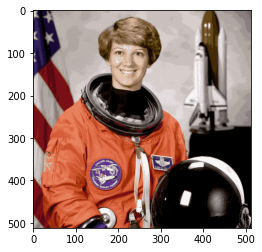

In [19]:
plt.imshow(img_compressed)
plt.show()

Increase or decrease n_clusters = number of colours if you want to see the differences.

## (Optional) Use the elbow method

You can try to use the Elbow method to find the optimal compression that loses the less color information.   
Try to plot the Inertia for K in [5, 10, 20, 30, 50, 70, 100] for instance  
⚠️ Long training

In [ ]:
inertias = []
ks = [5, 10, 20, 30, 50, 70, 100]
for k in ks:
    km_test = KMeans(n_clusters=k).fit(X)
    inertias.append(km_test.inertia_)

In [ ]:
plt.plot(ks, inertias)
plt.xlabel('k cluster number')
plt.ylabel('Inertia')
plt.show()

In [ ]:
#. n_cluster = 30 seems to be a good fit :P

🏁 **Congratulation! Don't forget to commit and push this notebook**